In [4]:
import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import matplotlib.pyplot as plt

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
image_dir = '/content/drive/MyDrive/Dataset Dr.Fruithy/Banana'

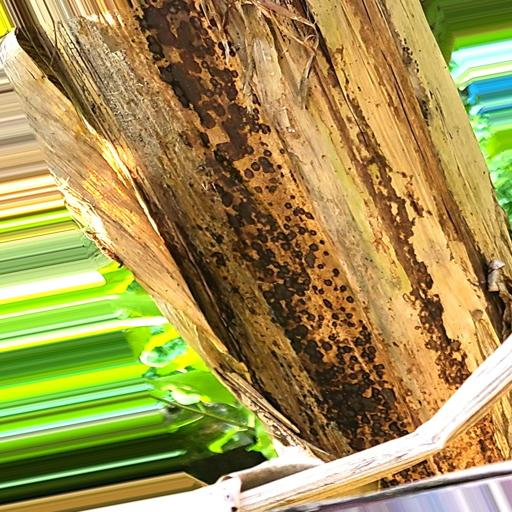

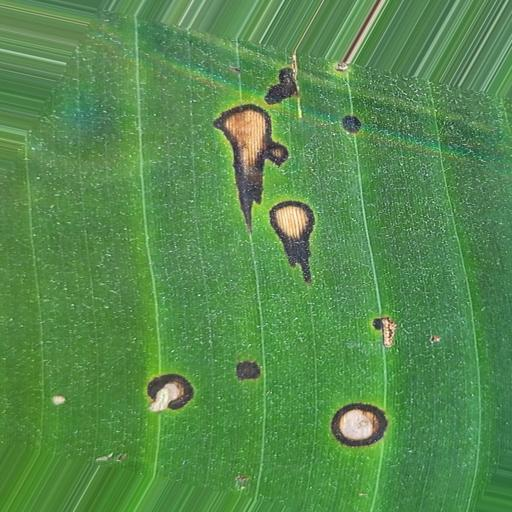

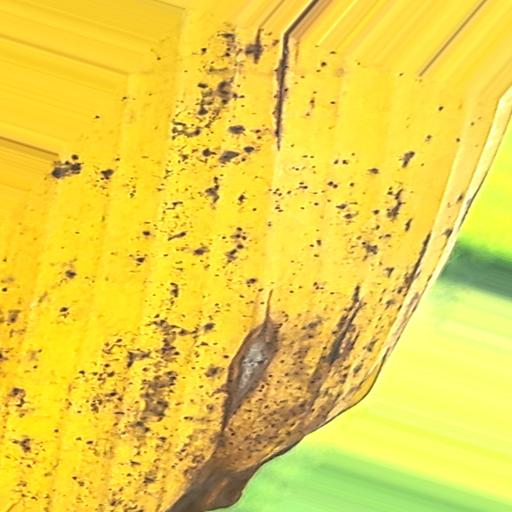

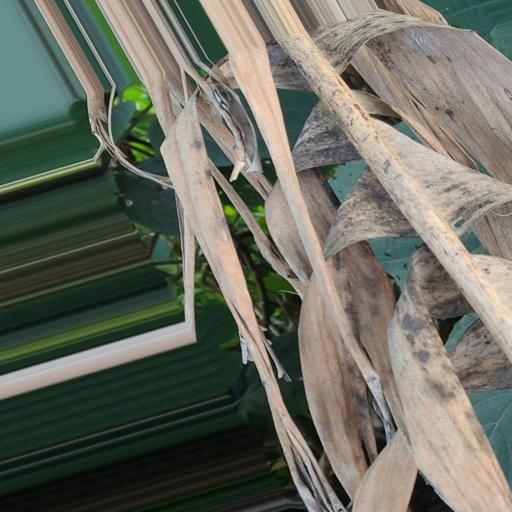

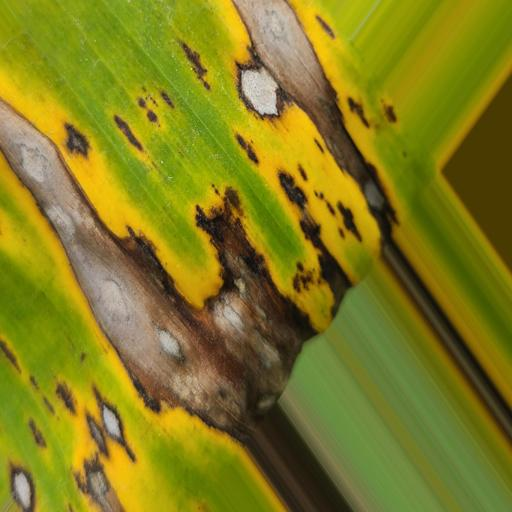

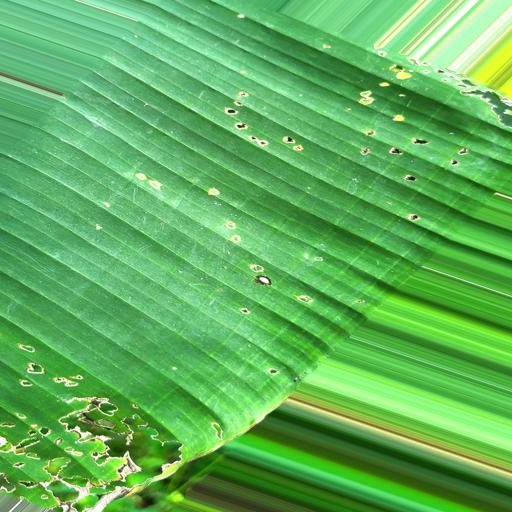

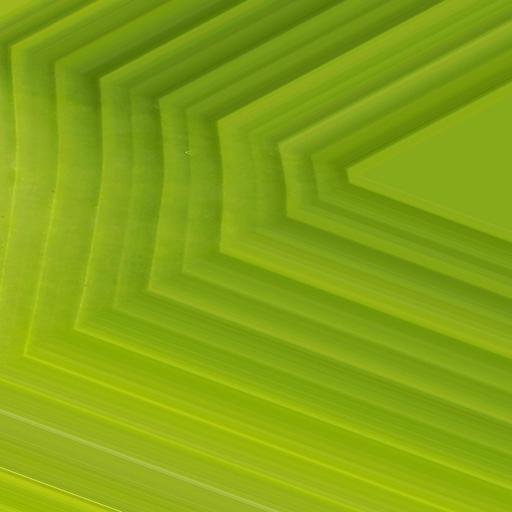

In [7]:
from IPython.display import display, Image, HTML

folders = [f for f in os.listdir(image_dir) if os.path.isdir(os.path.join(image_dir, f))]

for folder in folders:
    folder_path = os.path.join(image_dir, folder)
    images = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    if images:
        sample_image = images[0]
        image_path = os.path.join(folder_path, sample_image)
        display(HTML(f'<h3>{folder}</h3>'))
        display(Image(filename=image_path, width=200))

In [8]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    image_dir,
    shuffle=True,
    image_size = (240, 320),
    batch_size = 32)

Found 3264 files belonging to 7 classes.


In [9]:
dataset.class_names

['Banana Black Sigatoka Disease',
 'Banana Bract Mosaic Virus Disease',
 'Banana Healthy Leaf',
 'Banana Insect Pest Disease',
 'Banana Moko Disease',
 'Banana Panama Disease',
 'Banana Yellow Sigatoka Disease']

In [10]:
def split_dataset(ds, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1, shuffle=True):
    # menegatur
    dataset_size = len(ds)

    # Calculate split sizes
    train_size = int(train_ratio * dataset_size)
    val_size = int(val_ratio * dataset_size)
    test_size = dataset_size - train_size - val_size

    # Shuffle dataset if required
    if shuffle:
        ds = ds.shuffle(dataset_size)

    # Split dataset
    train_dataset = ds.take(train_size)
    val_dataset = ds.skip(train_size).take(val_size)
    test_dataset = ds.skip(train_size + val_size).take(test_size)

    return train_dataset, val_dataset, test_dataset

In [11]:
train_ds, val_ds, test_ds = split_dataset(dataset)

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [12]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(240,320),
    tf.keras.layers.Rescaling(1.0/255)
])

In [13]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode="horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2)),
    tf.keras.layers.RandomBrightness(0.1),
    tf.keras.layers.RandomContrast(0.1),
])

In [14]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.regularizers import l1

In [15]:
from tensorflow.keras.optimizers import Adam
resize_and_rescale,
data_augmentation,

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(240, 320, 3)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
  tf.keras.layers.Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

  tf.keras.layers.Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

  # Flatten layer
  tf.keras.layers.Flatten(),

  # Add fully connected layers with dropout and regularization
  tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(7, activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 240, 320, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 240, 320, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 120, 160, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 120, 160, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 120, 160, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 60, 80, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 80, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 60, 80, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 40, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 307200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      78,643,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 79,049,863 (301.55 MB)

 Trainable params: 79,048,967 (301.55 MB)

 Non-trainable params: 896 (3.50 KB)

In [18]:
history = model.fit(train_ds, epochs = 20, batch_size = 32, verbose = 1, validation_data = val_ds)

Epoch 1/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 283s 284ms/step - accuracy: 0.4476 - loss: 6.1024 - val_accuracy: 0.3844 - val_loss: 3.5041
Epoch 2/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 15s 187ms/step - accuracy: 0.6396 - loss: 2.2490 - val_accuracy: 0.6875 - val_loss: 1.7756
Epoch 3/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 15s 187ms/step - accuracy: 0.7101 - loss: 1.7191 - val_accuracy: 0.7844 - val_loss: 1.3922
Epoch 4/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 15s 187ms/step - accuracy: 0.7486 - loss: 1.5066 - val_accuracy: 0.8313 - val_loss: 1.3409
Epoch 5/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 15s 187ms/step - accuracy: 0.7980 - loss: 1.3370 - val_accuracy: 0.7906 - val_loss: 1.4743
Epoch 6/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 15s 187ms/step - accuracy: 0.8252 - loss: 1.2873 - val_accuracy: 0.9156 - val_loss: 1.1056
Epoch 7/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 15s 187ms/step - accuracy: 0.8613 - loss: 1.1387 - val_accuracy: 0.8750 - val_loss: 1.2263
Epoch 8/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 15s 188ms/step - accuracy: 0.8595 - loss: 1.1659 - val_acc

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

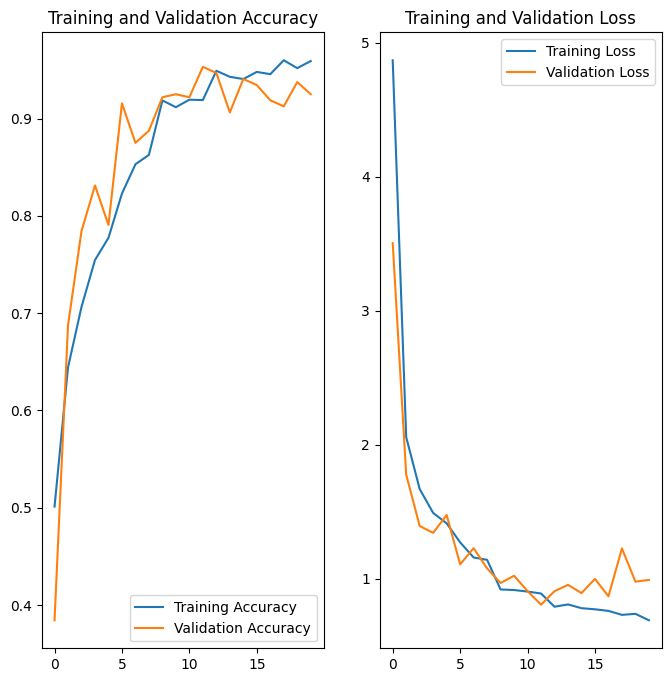

In [20]:
EPOCHS = 20
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [21]:
class_names = dataset.class_names
class_names

['Banana Black Sigatoka Disease',
 'Banana Bract Mosaic Virus Disease',
 'Banana Healthy Leaf',
 'Banana Insect Pest Disease',
 'Banana Moko Disease',
 'Banana Panama Disease',
 'Banana Yellow Sigatoka Disease']

first image to predict
actual label: Banana Panama Disease
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step
predicted label: Banana Panama Disease


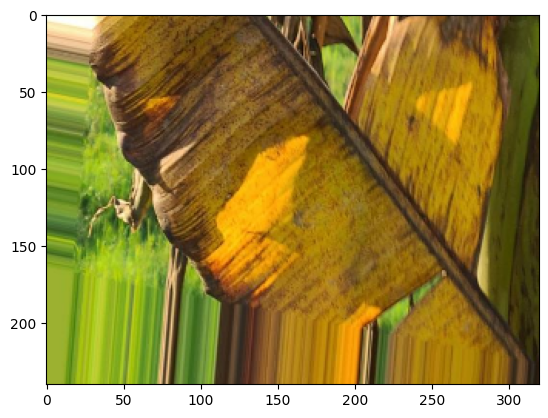

In [22]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [23]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


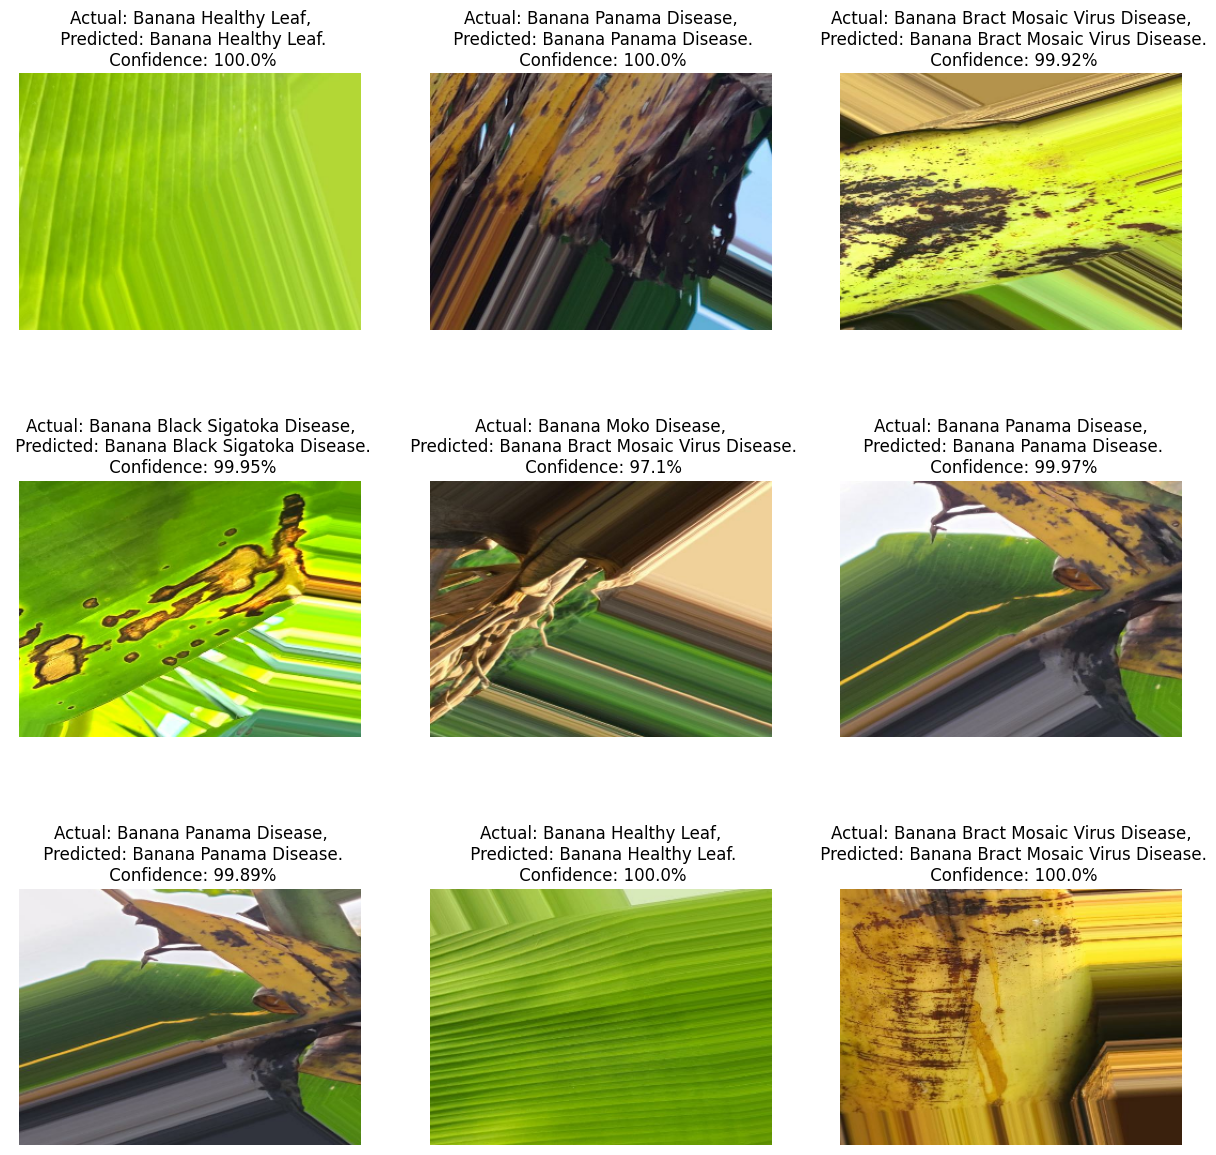

In [24]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

# Export Model

In [32]:
# Import the necessary packages
from tensorflow.keras.models import save_model

# Assuming that `model` is your trained CNN model
# Save the model to a .h5 file
save_model(model, 'banana_disease_detection_model.h5')
# model.save('apple_disease_detection_model.keras')

In [25]:
# model.save('/saved_model_banana', save_format='tf')

In [26]:
# import os

# # List all files and directories in the root directory
# for root, dirs, files in os.walk('/saved_model_apple'):
#     for name in files:
#         print(os.path.join(root, name))
#     for name in dirs:
#         print(os.path.join(root, name))

In [27]:
# from google.colab import files

# # Path to the directory you want to archive
# directory_to_zip = '/saved_model_apple'

# # Path and name for the output zip file
# output_filename = '/content/saved_model_banana.zip'

# # Create a zip archive
# shutil.make_archive(output_filename.replace('.zip', ''), 'zip', directory_to_zip)

# # Download the zip file
# files.download(output_filename)

In [28]:
# import subprocess
# import tensorflowjs as tfjs

In [29]:
# h5_model_path = "./saved_model/model.h5"
# model.save(h5_model_path)

In [30]:
# tfjs_target_dir = "./tfjs_model"
# tfjs.converters.save_keras_model(model, tfjs_target_dir)

# print("Model berhasil dikonversi ke format TensorFlow.js dan disimpan di:", tfjs_target_dir)

In [31]:
# zip_file_path = "./tfjs_model.zip"
# shutil.make_archive(zip_file_path.replace('.zip', ''), 'zip', tfjs_target_dir)

# print("Model TensorFlow.js berhasil dikompres ke file zip:", zip_file_path)